In [3]:
import numpy as np
import jax.numpy as jnp
from jax import random
# import jax.nn as nn
from flax import linen as nn  # Linen API
import jax
import matplotlib.pyplot as plt
from jax.tree_util import tree_map
import optax
import os
import pickle
import flax
from torch.utils import data
from torch.utils.data import Dataset

/home/roland/miniconda3/lib/python3.10/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [4]:
seed = 0
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 1000
num_training_steps = 20_000

In [5]:
print("the device used is", jax.devices(), jax.default_backend())
print(jax.device_count())

2023-05-17 11:19:53.237201: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


the device used is [CpuDevice(id=0)] cpu
1


# Dataloader and Diffusion : test equivalence between instant and step by step

In [6]:
def generateBatchPoints(key, distribution = 'spiral', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise

    if distribution == 'plus_sign' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= -1., maxval= 1.)
        axis = random.randint(key2, shape  = (batch_size,1), minval=0, maxval=2)
        positions = jnp.concatenate( (radius*axis,radius*(1 - axis)), axis=1  )
    
    # if distribution == 'two gaussians':
    #     key1, key2 = random.split(key)
    #     gauss_continuous_index = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)
    #     z = random.normal(key2, shape = (batch_size,2))

    #     positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    
    return(positions[...,None])


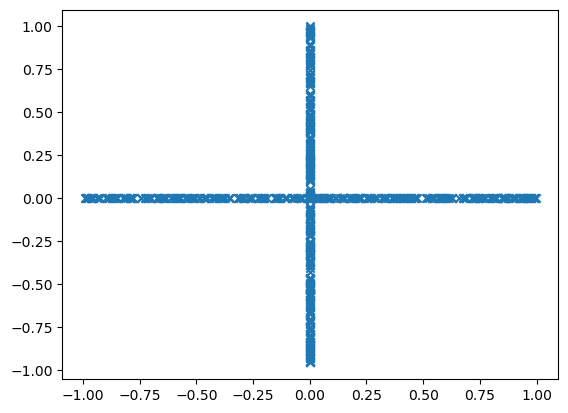

In [7]:
# Test
key = random.PRNGKey(seed)
samples = generateBatchPoints(key,  distribution = 'plus_sign')

plt.scatter( samples[:,0,0],samples[:,1,0], marker = 'x')
plt.show()

In [6]:
class distribution_dataset(Dataset):
    def __init__(self, key = random.PRNGKey(seed)) : 

        self.points = generateBatchPoints(key, distribution = 'spiral', batch_size = batch_size*50 )

    def __len__(self):
        return self.points.shape[0]//batch_size 

    def __getitem__(self, idx):
        return( self.points[ idx*batch_size:(idx+1)*batch_size , ...])

In [7]:
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple,list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

class NumpyLoader(data.DataLoader):
  def __init__(self, dataset, batch_size=1,
                shuffle=False, sampler=None,
                batch_sampler=None, num_workers=0,
                pin_memory=False, drop_last=False,
                timeout=0, worker_init_fn=None):
    super(self.__class__, self).__init__(dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        sampler=sampler,
        batch_sampler=batch_sampler,
        num_workers=num_workers,
        collate_fn=numpy_collate,
        pin_memory=pin_memory,
        drop_last=drop_last,
        timeout=timeout,
        worker_init_fn=worker_init_fn)

In [8]:
key , subkey = random.split(key)
trainset = distribution_dataset(subkey)
train_dataloader = NumpyLoader(trainset, batch_size=1, shuffle=True)

In [9]:
# test
for point in train_dataloader :
    print(point.shape)

(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)
(1, 512, 2, 1)


In [10]:
def diffuseBatch(key, positions, sigma) :
    batch_size = positions.shape[0]
    noise = random.normal(key, shape = (batch_size,2,1))
    return(positions + sigma*noise)

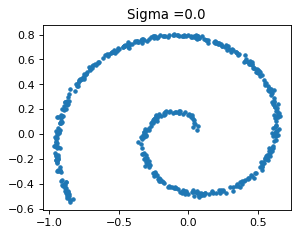

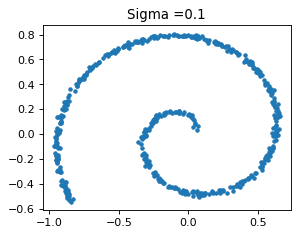

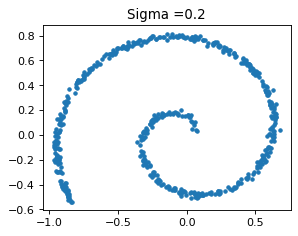

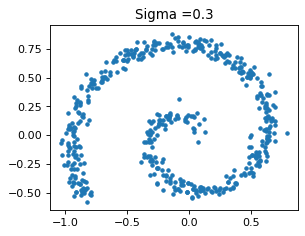

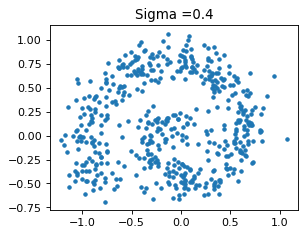

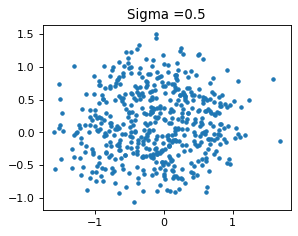

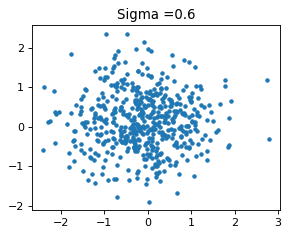

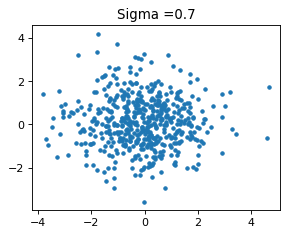

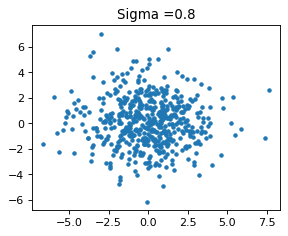

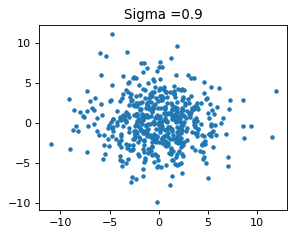

In [11]:
# Test
key = random.PRNGKey(seed)
key2, key3 = random.split(key)
samples = generateBatchPoints(key)

for sigmax10 in range(10) :
    sigma = 5*(sigmax10/10.)**4*np.ones((batch_size,1,1))
    samples_noisy = diffuseBatch(key2, samples, sigma)
    plt.figure(figsize=(4, 3), dpi=80)
    plt.scatter( samples_noisy[:,0,0], samples_noisy[:,1,0], marker = '.')
    plt.title("Sigma =" + str(sigmax10/10.))
    plt.show()

# MLP layer and model

In [12]:
# depreciated

# def initialiseMLPParams(key, shapes) :
#     """
#     Only valid for 1d MLP
#     """
#     params = []
#     for i, (shape1, shape2) in enumerate( zip(shapes[:-1], shapes[1:]) ) :
#         key, subkey = random.split(key)
#         weights = random.normal(key, shape= (shape2,shape1) )/jnp.sqrt(shape1) # /jnp.sqrt(shape1) allows to have same order of magnitude to output as input
#         biases = random.normal(subkey, shape= (shape2,1) )/jnp.sqrt(shape1)
#         params.append({ "weights":weights, "biases":biases })
#     key = random.split(key, num=1)[0]
#     return(key,params)

In [13]:
# depreciated

# #test 
# shapes = (2,128,134,2)
# key, params = initialiseMLPParams(key, shapes)
# tree_map(lambda x: print("la",x.shape)  , params ) 

In [14]:
# Depreciated
# def batchMLPNetwork(params, batch) :
#     """
#     input :
#     - params : should be a list of dictionaries with keys 'weights' and 'biases'
#     - batch : array of size (batch_size , 2, 1)
#     """
#     activation = batch
#     for layer in params[:-1] :
        
#         weights = layer['weights']
#         biases = layer['biases']
#         activation = nn.relu(jnp.matmul(weights,activation) + biases)
    
#     last_layer = params[-1]
#     weights = last_layer['weights']
#     biases = last_layer['biases']
#     logit = jnp.matmul(weights,activation) + biases
#     return(logit) 

In [15]:
# # test
# batch = jnp.ones(shape= (batch_size,2,1))
# batchMLPNetwork(params, batch)

In [16]:
class batch_MLP_bloc(nn.Module):                    # create a Flax Module dataclass
  out_dims: int

  @nn.compact
  def __call__(self, x):
    x = x.reshape((x.shape[0], -1))
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(128)(x)                 # create inline Flax Module submodules
    x = nn.relu(x)
    x = nn.Dense(self.out_dims)(x)       # shape inference
    return x



In [17]:
# test
model = batch_MLP_bloc(out_dims=10)                 # instantiate the MLP model

x = jnp.empty((4, 28, 28, 1))            # generate random data
variables = model.init(random.PRNGKey(42), x)   # initialize the weights
y = model.apply(variables, x)            # make forward pass
print(y)

print( model.tabulate(jax.random.PRNGKey(0), jnp.ones(x.shape)) )

del model

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

                             batch_MLP_bloc Summary                             
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module         ┃ inputs         ┃ outputs        ┃ params          ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│         │ batch_MLP_bloc │ float32[4,28,… │ float32[4,10]  │ Dense_0:        │
│         │                │                │                │   bias:         │
│         │                │                │                │ float32[128]    │
│         │                │                │                │   kernel:       │
│         │                │                │                │ float32[784,12… │
│         │                │                │                │ Dense_1:        │
│         │                │                │           

# learning diffusion step by step

In [18]:
@jax.jit
def PositionalEncoding(time_indices, embed_dimension = intermediate_embeding_time_dimension) :
    """ 
    - time_indices : shape (batch_size,) , should be int between 0 and num_timesteps
    - embed_dimension : dimension of the embeded time, *must be even* for definition of k in the function !
    """ 
     
    magic_number = 1000 # custom magic number addapted for embed_dimension = 128 
    times = time_indices.reshape( (1,-1) )
    k = jnp.arange( 0, embed_dimension//2 ).reshape((-1,1))

    ### might not be the most elegant way to do this ? :

    embedding = jnp.array([ jnp.cos( times/(magic_number**(2.*k/embed_dimension)) ) , jnp.sin( times/(magic_number**(2.*k/embed_dimension)) ) ])
    # embedding shape is (2, embed_dimension/2, batch_size) and should become (batch_size, embed_dim)
    embedding = jnp.transpose(embedding, (2,1,0))
    embedding = embedding.reshape((-1, embed_dimension ))

    ###

    return(embedding)


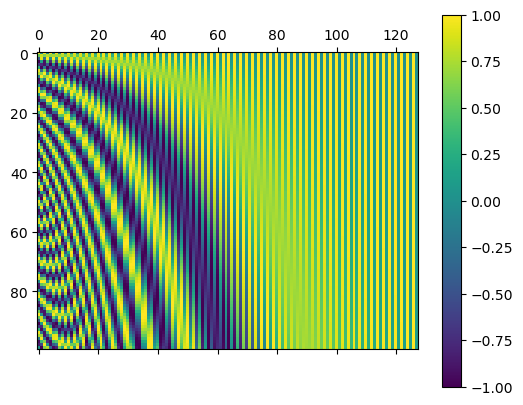

In [19]:
# test 
embedded = PositionalEncoding(jnp.arange(0,100))

plt.matshow(embedded)
plt.colorbar()
plt.show()

In [20]:
# depreciated
# @jax.jit
# def score(parameters,batch,time_indices) :
#     """
#     input :
#     - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_global' for the respectives MLP
#     - batch : positions batch shape (batch_size, 2, 1)
#     - time_indices : shape (batch_size,) should be integers (float of int)
#     output :
#     - shape (batch_size,2,1)
#     """
#     time_embedding = PositionalEncoding(time_indices)
#     params_times, params_positions, params_global = parameters['params_times'], parameters['params_positions'], parameters['params_global']

#     time_embedding = batchMLPNetwork(params_times, time_embedding[...,None])
#     position_embedding = batchMLPNetwork(params_positions, batch)

#     global_embedding = jnp.concatenate( (time_embedding, position_embedding) , axis = 1)

#     result = batchMLPNetwork(params_global, global_embedding)
#     return(result)

In [21]:
batch_MLP_embedding_layers = batch_MLP_bloc(out_dims= intermediate_features_embedding) 
batch_MLP_final_layers = batch_MLP_bloc(out_dims= 2)

@jax.jit
def score(parameters,batch,time_indices) :

    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    - time_indices : shape (batch_size,) should be integers (float of int)
    output :
    - shape (batch_size,2,1)
    """
    time_embedding = PositionalEncoding(time_indices)
    params_times, params_positions, params_global = parameters['params_times'], parameters['params_positions'], parameters['params_global']

    time_embedding = batch_MLP_embedding_layers.apply( params_times, time_embedding)
    position_embedding = batch_MLP_embedding_layers.apply( params_positions, batch)
    

    global_embedding = jnp.concatenate( (time_embedding, position_embedding) , axis = 1)

    result = batch_MLP_final_layers.apply( params_global, global_embedding )[:,:,None]

    return(result)

In [22]:
# depreciated
# def generateParameters(key):
#     shapes_times = ( intermediate_embeding_time_dimension, 128,128, intermediate_features_embedding)
#     shapes_positions = ( 2, 128,128 ,intermediate_features_embedding)
#     shapes_global = (2*intermediate_features_embedding, 256, 256, 2)

#     key, params_times = initialiseMLPParams(key, shapes_times)
#     key, params_positions = initialiseMLPParams(key, shapes_positions)
#     key, params_global = initialiseMLPParams(key, shapes_global)

#     parameters = { 'params_times' : params_times,
#                 'params_positions' : params_positions,
#                 'params_global' : params_global }
    
#     return(key,parameters)

In [23]:
def generateParameters(key):

    key, key1, key2, key3 = random.split(key,4)

    # useless to put batch_size instead of '1'
    typical_batch = jnp.empty((batch_size, 2,1))
    typical_time_batch = jnp.empty((batch_size,intermediate_embeding_time_dimension))
    typical_embedded_batch = jnp.empty((batch_size, 2*intermediate_features_embedding))
    
    params_times = batch_MLP_embedding_layers.init(key1, typical_time_batch)
    params_positions = batch_MLP_embedding_layers.init(key2, typical_batch)
    params_global = batch_MLP_final_layers.init(key3, typical_embedded_batch)

    parameters = { 'params_times' : params_times,
                'params_positions' : params_positions,
                'params_global' : params_global }
    
    return(key,parameters)

In [24]:
# test 
key, parameters = generateParameters(key)

times = jnp.ones((batch_size,))
batch = random.normal(key, (batch_size,2,1) )
result = score(parameters, batch, times )
print(result.shape)

(512, 2, 1)


In [25]:
def timeIndices2sigma(time_indices) :
    """ 
    - time_indices : shape (batch_size,) integers 
    """ 
    # we choose a simple sigma for now
    # return( 5*(time_indices*1./num_timesteps)**4) # **4 because **2 for def of sigma and **2 for modulation of timesteps 

    # magic metaparameters from song sde paper
    sigma_max = 20.
    sigma_min = 0.01
    return( (sigma_min*(sigma_max/sigma_min)**(time_indices*1.0/num_timesteps))**2 ) # sigma is already squarred here !

In [26]:
@jax.jit
def batch_loss(parameters,batch, key) :
    key, key2, key3, key4 = random.split(key,4)

    # sampling times
    time_indices = random.randint(key2, shape = (batch_size,), minval= 0, maxval= num_timesteps)
    sigmas = timeIndices2sigma(time_indices)

    # sampling initial data 
    # batch = generateBatchPoints(key3, distribution = 'spiral', batch_size=batch_size)
    noisy_batch = diffuseBatch(key4, batch, sigmas[:,None,None])
    # loss = jnp.sum( 1./sigmas[:,None,None]*( score(parameters,noisy_batch,time_indices) + (noisy_batch - batch)/(1.*sigmas[:,None,None]) )**2 )

    loss = jnp.mean(( score(parameters,noisy_batch,time_indices) + (noisy_batch - batch)/(1.*sigmas[:,None,None]) )**2 )
    return(loss)
    

In [27]:
# test 
batch = jnp.ones((batch_size,2,1))
batch_loss(parameters,batch, key)

Array(61.176292, dtype=float32)

In [28]:
def train_or_retrieve_model(key, savingFileName = "parameters.npy") :

    if os.path.isfile(savingFileName) :
        with open(savingFileName, 'rb') as file:
            parameters = pickle.load(file)
    else :
        key, parameters = generateParameters(key)

        learning_rate = 0.001
        optimizer = optax.adam(learning_rate)
        opt_state = optimizer.init(parameters)

        loss_cache = []
        i = 0
        while i < num_training_steps :

            for batch in train_dataloader :
                batch = batch[0]

                key = random.split(key, 1)[0]
                value, grads = jax.value_and_grad(batch_loss)(parameters, batch, key)
                loss_cache.append(value)
                if i%500 == 0 :
                    print( "step :", str(i), "   -   loss :", str(np.mean(loss_cache)))
                    loss_cache = [] 
                updates, opt_state = optimizer.update(grads, opt_state)
                parameters = optax.apply_updates(parameters, updates)
                i+=1

        with open(savingFileName, 'wb') as file:
            pickle.dump(parameters, file)
    return(parameters)


In [29]:
parameters = train_or_retrieve_model(key, savingFileName = "parameters.npy")

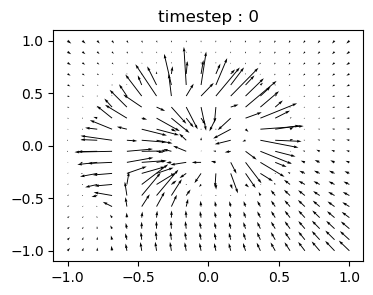

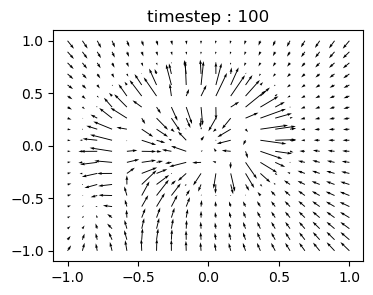

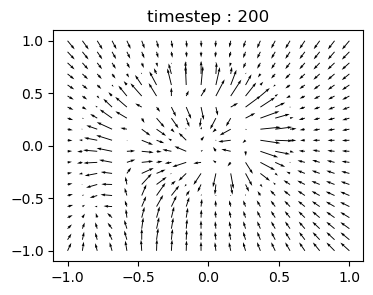

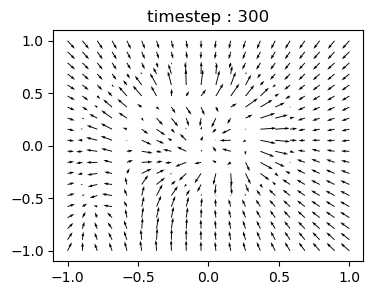

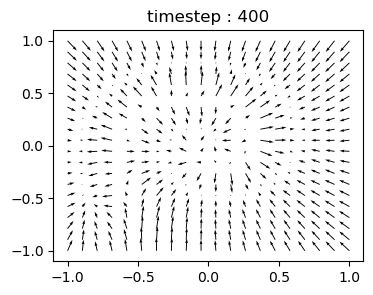

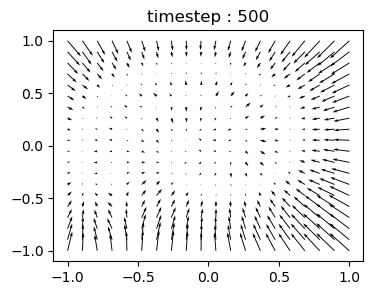

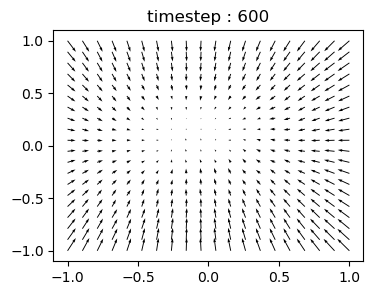

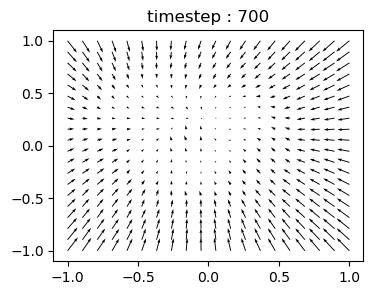

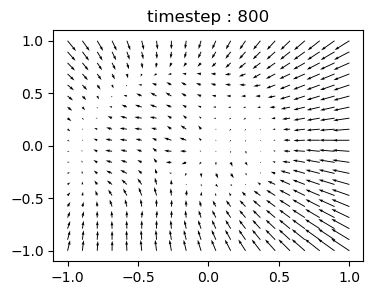

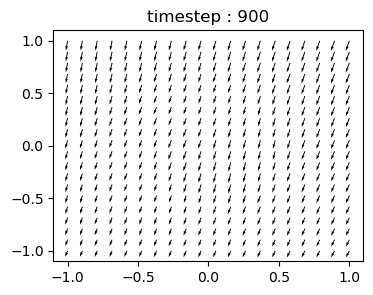

In [30]:
# test 
# Batch_size must be superior to 400 for this test
for timestep in range(0,num_timesteps,100) :
    x,y = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
    X = x.flatten()
    Y = y.flatten()
    batch = np.zeros((batch_size,2,1))
    batch[:400] = np.concatenate( [X[:,None],Y[:,None]], axis = 1)[...,None]
    time_indices = np.ones((batch_size,))*timestep
    scores = score(parameters,batch,time_indices)[:400]
    u,v = scores[:,0,0], scores[:,1,0]
    plt.figure(figsize=(4,3))
    plt.quiver(x,y,u,v)
    plt.title( "timestep : " + str(timestep))
    plt.show()

In [1]:
def timeSteps2stepSize(num_timesteps : int, batch_size : int):
    """ 
    - num_timesteps : int 
    - batch_size : int

    returns :
    - stepSize : shape (num_timesteps, batch_size) 
    """ 
    stepSize = jnp.ones((batch_size,num_timesteps)).T*1.0/num_timesteps
    return(stepSize)

In [32]:
from functools import partial

@partial(jax.jit, static_argnums=0)
def corrector(num_iter_per_timestep, parameters, stepSize, batch, i, key) :
    for j in range(num_iter_per_timestep ):
      key, subkey = random.split(key)
      z = random.normal(subkey, (batch_size,2,1))
      batch = batch + stepSize[i,:,None,None]*score(parameters,batch,time_indices[i]) + jnp.sqrt(2*stepSize[i,:,None,None])*z
    return(key, batch)

In [33]:
@jax.jit
def predictor(key, batch, sigmas_ip1, sigmas_i, i, parameters ) :
    key, subkey = random.split(key)
    z = random.normal(subkey, (batch_size,2,1))
    batch = batch + (sigmas_ip1 - sigmas_i)[:,None,None]*score(parameters,batch,time_indices[i+1])*2
    batch = batch + jnp.sqrt(sigmas_ip1 - sigmas_i)[:,None,None]*z
    return(key, batch)

In [34]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    prior_sigmas = timeIndices2sigma(time_indices[-1])
    batch = prior_sigmas[:,None,None]*random.normal(key1, (batch_size,2,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        sigmas_ip1 = timeIndices2sigma(time_indices[i+1]) 
        sigmas_i = timeIndices2sigma(time_indices[i])

        key, batch = predictor(key, batch, sigmas_ip1, sigmas_i, i, parameters )
        
        # num_iter_per_timestep = 0
        # key, batch = corrector(num_iter_per_timestep, parameters, stepSize, batch, i, key)


        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch[:,0,0], batch[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)


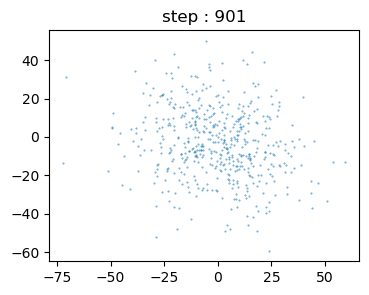

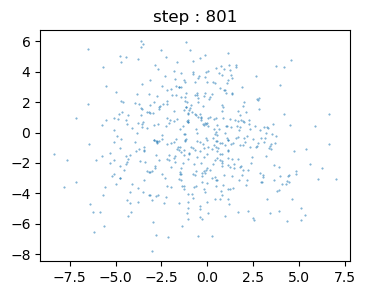

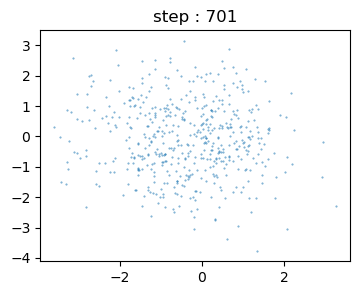

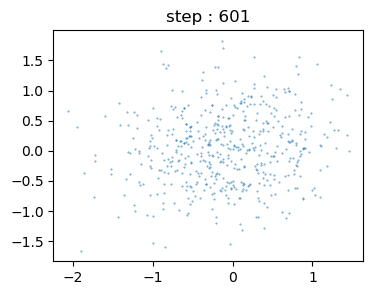

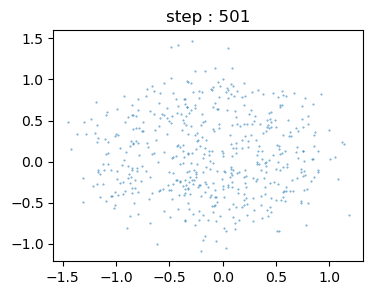

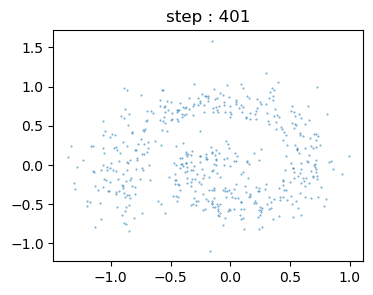

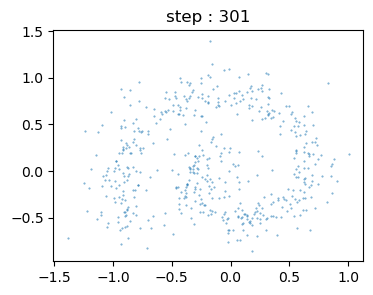

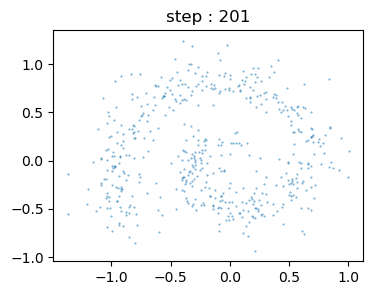

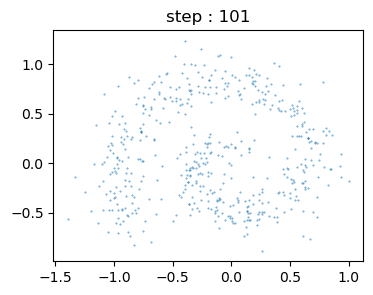

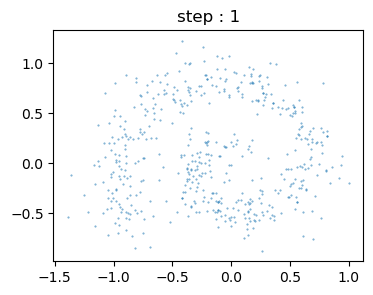

In [35]:
# test 
key, = random.split(key,1)
result = generate_batch(key, parameters)


In [36]:
@jax.jit
def deterministic_predictor(key, batch, sigmas_ip1, sigmas_i, i, parameters ) :
    batch = batch + (sigmas_ip1 - sigmas_i)[:,None,None]*score(parameters,batch,time_indices[i+1])
    return(key, batch)

In [37]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_deterministic_batch(key, parameters, time_indices = time_indices) :
    
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """

    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    prior_sigmas = timeIndices2sigma(time_indices[-1])
    batch = prior_sigmas[:,None,None]*random.normal(key1, (batch_size,2,1)) # prior distribution
    for i in range(num_timesteps- 2, 0, -1) :

        sigmas_ip1 = timeIndices2sigma(time_indices[i+1]) 
        sigmas_i = timeIndices2sigma(time_indices[i])

        key, batch = deterministic_predictor(key, batch, sigmas_ip1, sigmas_i, i, parameters )

        ### test 
        if i%100 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch[:,0,0], batch[:,1,0], s = 0.2, alpha = 0.7)
          plt.title("step : " + str(i))
          plt.show()
        ###

    return(batch)

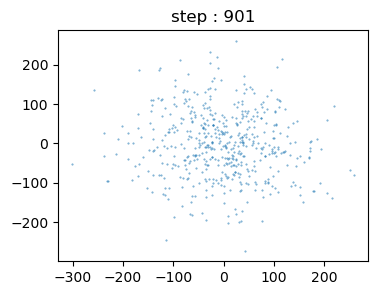

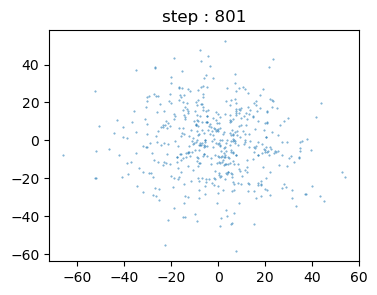

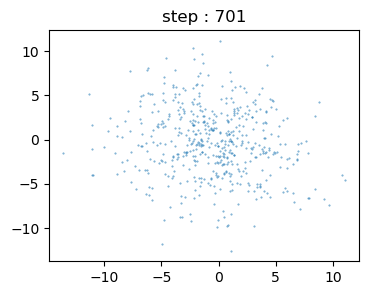

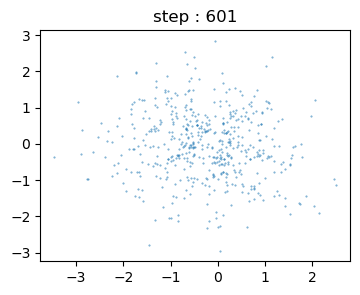

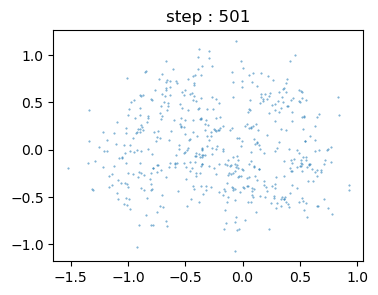

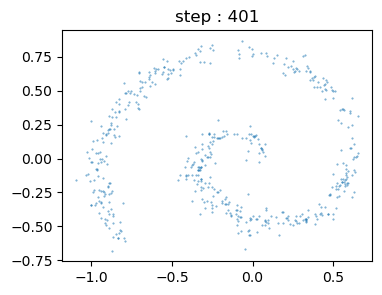

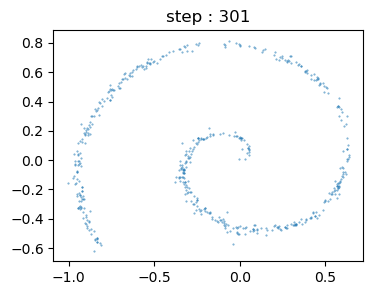

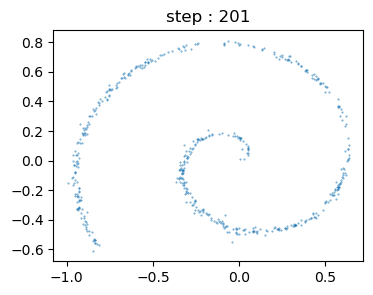

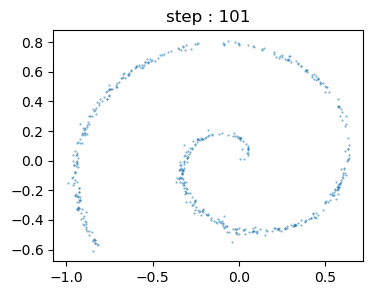

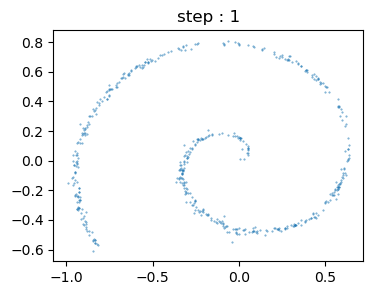

In [38]:
result = generate_deterministic_batch(key, parameters)